# CASO DE ESTUDIO 1
*Case of study 1*

## Data fetching

### Gastos

In [208]:
import pandas as pd

gastos = pd.read_csv('CasoMarketing-Gasto.csv')
gastos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Semana          48 non-null     int64 
 1   GastoAdwords    48 non-null     object
 2   GastoFacebook   48 non-null     object
 3   GastoInstagram  48 non-null     object
 4   GastoOrganico   48 non-null     object
dtypes: int64(1), object(4)
memory usage: 2.0+ KB


| **Column name** | **Feature description** |
|----------------:| :--------------------- |
| *Semana*        | Week of the data |
| *GastoAdwords*  | Google advertisement cost |
| *GastoFacebook* | Facebook avertisement cost |
| *GastoInstagram*| Intsgram advertisement cost |
| *GastoOrganico* | Company's page cost |

The table must be cleaned and processed.

In [209]:
gastos.head()

,Semana,GastoAdwords,GastoFacebook,GastoInstagram,GastoOrganico
0,1,"$58,587.80","$13,166.12","$25,644.37",$0.00
1,2,"$67,295.35","$15,130.57","$25,603.19",$0.00
2,3,"$43,330.19","$14,983.00","$28,962.36",$0.00
3,4,"$60,818.66","$14,294.78","$29,601.45",$0.00
4,5,"$43,593.73","$18,685.01","$29,219.29",$0.00


In [210]:
gastos.drop('GastoOrganico', axis=1, inplace=True) # description specifies it is always 0

to_float = lambda x: float(x.replace('$', '').replace(',', '')) if isinstance(x, str) else x
gastos = gastos.applymap(to_float)

gastos.columns = [x.replace('Gasto', '') for x in gastos.columns] # For later convinience
gastos.rename(columns={'Adwords':'AdWords'}, inplace=True)
    
gastos.head()

,Semana,AdWords,Facebook,Instagram
0,1,58587.80,13166.12,25644.37
1,2,67295.35,15130.57,25603.19
2,3,43330.19,14983.00,28962.36
3,4,60818.66,14294.78,29601.45
4,5,43593.73,18685.01,29219.29


## Operaciones

In [211]:
ops = pd.read_csv('CasoMarketing-Operaciones.csv')
ops.head()

,Prospecto,Semana,Verificado,Oe,PrioridadProspecto,Canal
0,1,1,Si,6.0,Prioridad Alta,Organico
1,2,1,No,NaN,Prioridad Alta,Organico
2,3,1,Si,5.0,Prioridad Alta,Facebook
3,4,1,Si,14.0,Prioridad Alta,AdWords
4,5,1,Si,14.0,Prioridad Alta,AdWords


| **Column name** | **Feature description** |
|----------------:| :--------------------- |
| *Prospecto*     | Prospect ID |
| *Semana*        | Week of the data |
| *Verificado*    | Wether the prospect gave his/her credit card info. Main key to meassure success |
| *Oe*            | Days between account created and account verification |
| *PrioriddProspecto* | Prospect priority assigned by a ML algorithm |
| *Canal*         | Channel from where the client came from |

The table must be cleaned and processed.

In [212]:
ops.drop('Prospecto', axis=1, inplace=True) # Information about the identity of the prospect is irrelevant
ops['Oe'].fillna(-1, inplace=True)  # NA values would cause problems while graphing, they mean prosped was not verified
ops['Oe'] = ops['Oe'].apply(lambda x: int(x))

ops.sample(5)

,Semana,Verificado,Oe,PrioridadProspecto,Canal
1154,9,No,-1,Prioridad Baja,Organico
7095,35,Si,4,Prioridad Alta,Instagram
8075,38,No,-1,Prioridad Media,Organico
6316,32,No,-1,Prioridad Media,AdWords
9019,41,Si,5,Prioridad Alta,Organico


## Combine the data

In [213]:
data = ops.merge(gastos, on='Semana', how='inner')
data.sample(5)

,Semana,Verificado,Oe,PrioridadProspecto,Canal,AdWords,Facebook,Instagram
7855,37,No,-1,Prioridad Media,Organico,110568.44,37428.15,67541.95
9271,42,Si,2,Prioridad Media,Instagram,90368.40,38617.02,73584.19
5458,29,No,-1,Prioridad Media,Organico,95593.15,28879.19,78856.28
7563,36,No,-1,Prioridad Alta,Organico,94392.20,33821.11,63647.88
4760,26,No,-1,Prioridad Baja,AdWords,80963.53,31203.06,67864.84


Simplify and process

In [214]:
data['Gasto'] = data.apply(lambda row: row[row['Canal']] if row['Canal'] in ['AdWords', 'Facebook', 'Instagram'] else 0, axis=1)
data.drop(['AdWords', 'Facebook', 'Instagram'], axis=1, inplace=True)
data.sample(5)

,Semana,Verificado,Oe,PrioridadProspecto,Canal,Gasto
8264,39,No,-1,Prioridad Baja,AdWords,98659.57
5252,28,No,-1,Prioridad Media,Facebook,30487.31
6849,34,Si,13,Prioridad Alta,Organico,0.00
3050,19,No,-1,Prioridad Alta,Organico,0.00
10206,44,No,-1,Prioridad Baja,Organico,0.00


# MAE

In [215]:
import seaborn as sea
import matplotlib.pyplot as plt

sea.set_theme()
sea.set_context('paper')

<Axes: xlabel='Semana'>

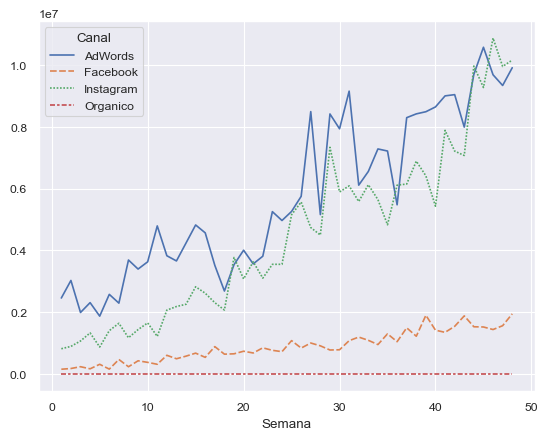

In [216]:
semana_canal = data.groupby(['Semana', 'Canal']).sum()['Gasto']
semana_canal = semana_canal.unstack(level=-1)
sea.lineplot(semana_canal)

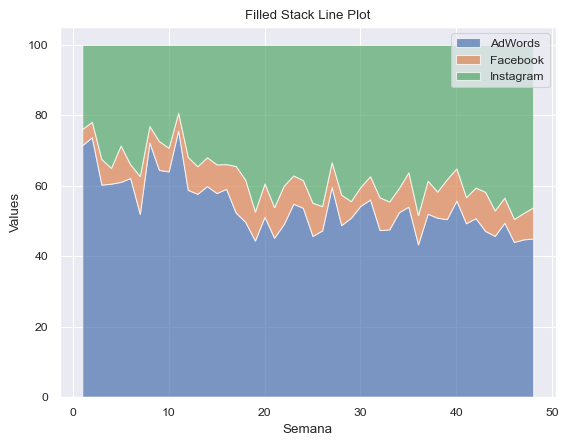

In [217]:
semana_canal['Total'] = semana_canal.sum(axis=1)
for col in list(semana_canal.columns):
    semana_canal[col] /= (semana_canal['Total']/100)
semana_canal.drop(['Organico', 'Total'], axis=1, inplace=True)

plt.stackplot(range(1, 49), semana_canal['AdWords'], semana_canal['Facebook'], semana_canal['Instagram'],
              labels=['AdWords','Facebook','Instagram'], alpha=0.7)
plt.legend(loc='upper right')
plt.title('Filled Stack Line Plot')
plt.xlabel('Semana')
plt.ylabel('Values')
plt.show()

<Axes: xlabel='Semana'>

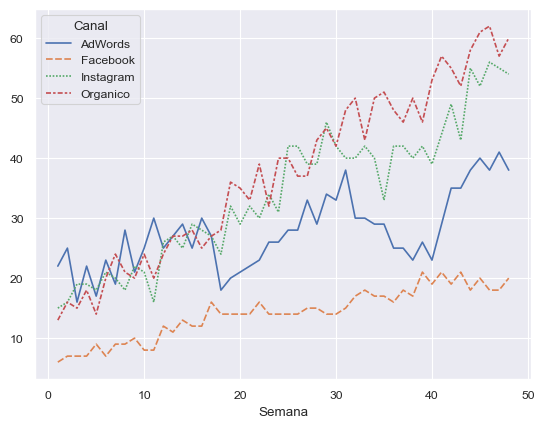

In [218]:
semana_canal = data[data['Oe']>0].groupby(['Semana', 'Canal']).count()['Gasto']
semana_canal = semana_canal.unstack(level=-1)
sea.lineplot(semana_canal)

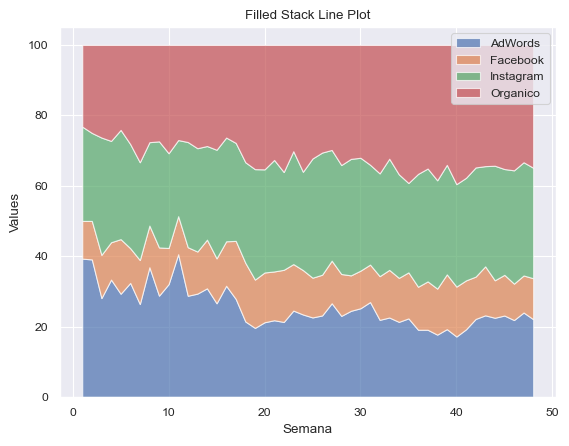

In [219]:
semana_canal['Total'] = semana_canal.sum(axis=1)
for col in list(semana_canal.columns):
    semana_canal[col] /= (semana_canal['Total']/100)
semana_canal.drop('Total', axis=1, inplace=True)

plt.stackplot(range(1, 49), semana_canal['AdWords'], semana_canal['Facebook'], semana_canal['Instagram'], semana_canal['Organico'],
              labels=['AdWords','Facebook','Instagram', 'Organico'], alpha=0.7)
plt.legend(loc='upper right')
plt.title('Filled Stack Line Plot')
plt.xlabel('Semana')
plt.ylabel('Values')
plt.show()

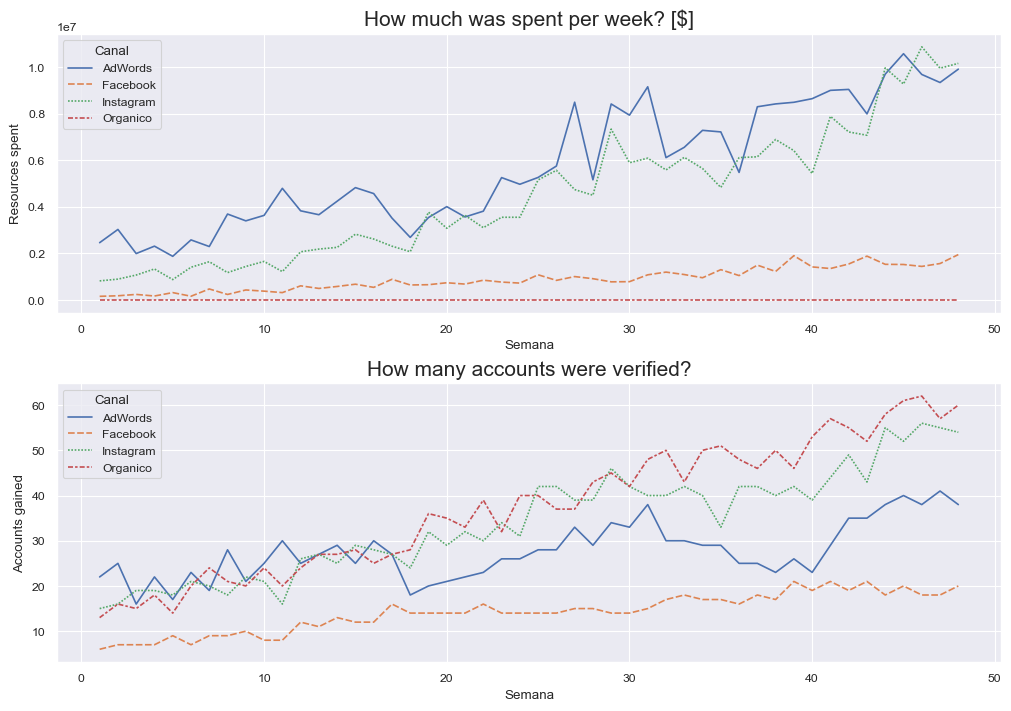

In [220]:

import matplotlib.gridspec as gridspec

fig = plt.figure(constrained_layout=True, figsize=(10,7))
spec = gridspec.GridSpec(ncols=1, nrows=2, figure=fig)
ax0 = fig.add_subplot(spec[0, 0])
ax1 = fig.add_subplot(spec[1, 0])

semana_canal = data.groupby(['Semana', 'Canal']).sum()['Gasto']
semana_canal = semana_canal.unstack(level=-1)
sea.lineplot(semana_canal, ax=ax0)
ax0.set_ylabel('Resources spent')
ax0.set_title('How much was spent per week? [$]', size=15)

semana_canal2 = data[data['Oe']>0].groupby(['Semana', 'Canal']).count()['Gasto']
semana_canal2 = semana_canal2.unstack(level=-1)
sea.lineplot(semana_canal2, ax=ax1)
ax1.set_ylabel('Accounts gained')
ax1.set_title('How many accounts were verified?', size=15)

fig.savefig('Gasto-Verificado.png', dpi=600)

In [221]:
data[data['Oe']>0].groupby('Canal').count().iloc[3, 3] / data[data['Oe']>0].shape[0]

0.3305131506345411

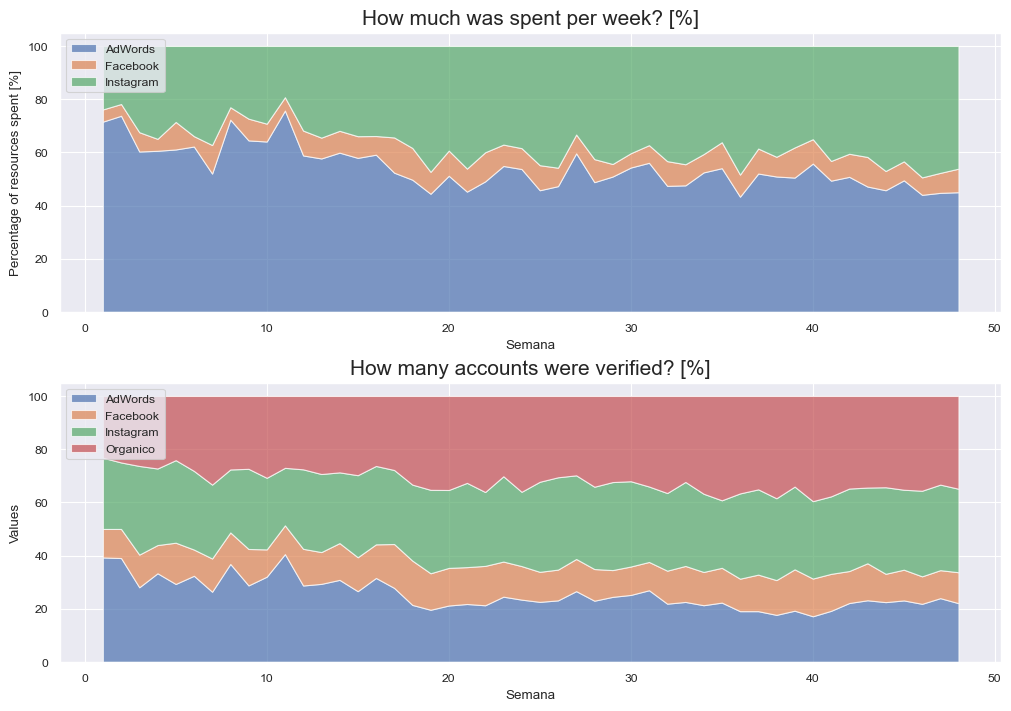

In [222]:

fig = plt.figure(constrained_layout=True, figsize=(10,7))
spec = gridspec.GridSpec(ncols=1, nrows=2, figure=fig)
ax2 = fig.add_subplot(spec[0, 0])
ax3 = fig.add_subplot(spec[1, 0])

semana_canal['Total'] = semana_canal.sum(axis=1)
for col in list(semana_canal.columns):
    semana_canal[col] /= (semana_canal['Total']/100)
semana_canal.drop(['Organico', 'Total'], axis=1, inplace=True)

ax2.stackplot(range(1, 49), semana_canal['AdWords'], semana_canal['Facebook'], semana_canal['Instagram'],
              labels=['AdWords','Facebook','Instagram'], alpha=0.7)
ax2.legend(loc='upper left')
ax2.set_xlabel('Semana')
ax2.set_ylabel('Percentage of resources spent [%]')
ax2.set_title('How much was spent per week? [%]', size=15)

semana_canal2['Total'] = semana_canal2.sum(axis=1)
for col in list(semana_canal2.columns):
    semana_canal2[col] /= (semana_canal2['Total']/100)
semana_canal2.drop('Total', axis=1, inplace=True)

ax3.stackplot(range(1, 49), semana_canal2['AdWords'], semana_canal2['Facebook'], semana_canal2['Instagram'], semana_canal2['Organico'],
              labels=['AdWords','Facebook','Instagram', 'Organico'], alpha=0.7)
ax3.legend(loc='upper left')
ax3.set_xlabel('Semana')
ax3.set_ylabel('Values')
ax3.set_title('How many accounts were verified? [%]', size=15)

fig.savefig('Gasto-Verificado-Porcentaje.png', dpi=600)

From the previous two graphs it is possible to conclude that, despite not needing any maintanance, the company's website was the biggest contributor of verified accounts (38% of them) throught the 48 weeks. It would be advisable to invest into its development and improvement to reach and maintaion a higher amount of audience.

On the contrary, the accounts gained through Facebook remain stagnant despite the increase in the marketing budget assigned to the platform. Further observation should be made to confirm this tendency in order to reasign that extra budget.

In [223]:
data.sample()

,Semana,Verificado,Oe,PrioridadProspecto,Canal,Gasto
1288,10,Si,1,Prioridad Alta,AdWords,67250.72


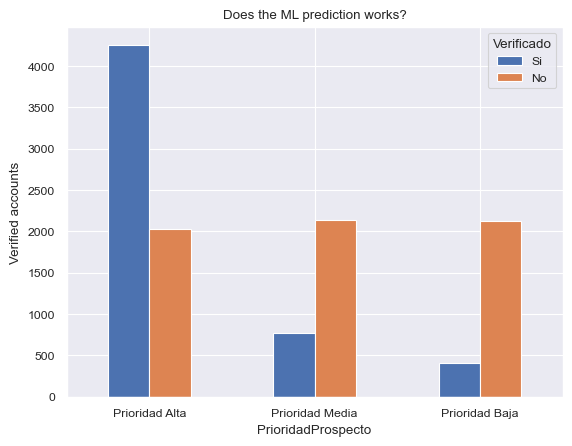

In [224]:
prioridad_verificado = data.groupby(['PrioridadProspecto', 'Verificado']).count().iloc[:, 0]
prioridad_verificado = prioridad_verificado.unstack(level=-1)
prioridad_verificado = prioridad_verificado[['Si', 'No']]

order = ['Prioridad Alta', 'Prioridad Media', 'Prioridad Baja']
mapping = {p: x for x, p in enumerate(order)}
key = prioridad_verificado.index.map(mapping)

prioridad_verificado.iloc[key.argsort()].plot(kind='bar', rot=0)
plt.ylabel('Verified accounts')
plt.title('Does the ML prediction works?')

plt.savefig('ML.png', bbox_inches='tight', dpi=600)

As per the previous bar plot of the number of verified account based on the outcome of the prediction model used by the company, it can be determined that while the label 'Prioridad Alta' manages to accurately predict if a costumer is going to be verified, the  other two categorical labels ('Prioridad Media' and 'Prioridad Baja') behave on a very similar way, beating the purpose of them being two separate categories.

Moreover, neither of the categories help the model predict the existance of non-verified accounts ('No' label). It would be beneficial to add a 4th category to include them.

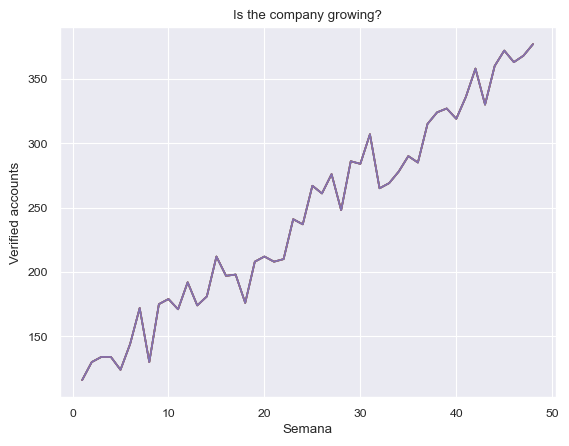

In [226]:
semanas = data.groupby('Semana').count()
semanas.plot(legend=False)
plt.ylabel('Verified accounts')
plt.title('Is the company growing?')
plt.savefig('Growth.png', bbox_inches='tight', dpi=600)

Lastly, on a simple time comparison between the number of verified accounts through the data weeks, it can be see the clear increment of the users. Meaning the company is having a significant and stable growth despite the aforementioned issues found.